In [1]:
import gymnasium as gym
import torch
import cv2
import numpy as np
import torch
from submissions.reappearance import dict_reappearance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/hyunwoo/miniconda3/envs/rl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

In [3]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self.env = env
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    
    _, _ = self.env.reset()
    
    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info

  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

In [4]:
import os 
import pickle

directory = "./maps"
os.makedirs(directory, exist_ok=True)

num_reappearances = 5 # 아래에도 쓰이는 지역변수임 

map_dirs = []

for i in range(num_reappearances):
    map_filename = f"map_{i + 1}"
    map_dir = f"{directory}/{map_filename}"
    os.makedirs(map_dir, exist_ok=True)
    map_dirs.append(map_dir)
    filepath = os.path.join(map_dir, map_filename)

In [5]:
def animate(imgs, team, map_idx):
    import cv2
    import os
    
    store_dir = f"{map_dirs[map_idx]}/{team}"
    os.makedirs(store_dir, exist_ok=True)
    
    video_path = os.path.join(store_dir, "video.webm")    
    
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_path, fourcc, 10, (width, height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

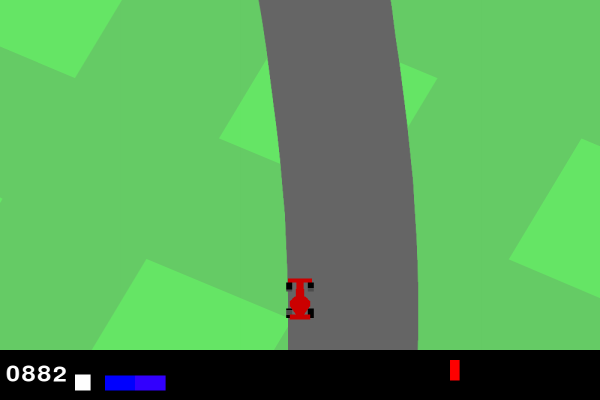

Coarse-0 | Score: 875.6889679715164


OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Coarse-1 | Score: 890.7639344262157


OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [6]:
submission_team = ["달려라하니"] # Test하고 싶은 조만 추가할 것. 

for team in submission_team:
    team_submission = dict_reappearance[team]
    DQN = team_submission.model
    
    avg_scores = 0.0
    
    for map_idx in range(num_reappearances):
        
        eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array', lap_complete_percent=0.60)
        eval_env.np_random = np.random.Generator(np.random.PCG64(np.random.SeedSequence(map_idx * 42)))
        eval_env.reset()
        
        n_actions = eval_env.action_space
        
        agent = DQN(n_actions, **team_submission.hyperparameters)
        agent.target_network.load_state_dict(
            torch.load(team_submission.model_path, map_location=device))
        
        frames = []
        scores = 0
        
        eval_env = CarEnvironment(eval_env)
        s, _ = eval_env.reset()
        
        done, ret = False, 0
        
        from PIL import Image as PILImage
        def render2img(_img): return PILImage.fromarray(_img, "RGB")
        handle = display(None, display_id=True)
        while not done:
            
            s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            a = agent.select_action(s, evaluation_phase=True)
            discrete_action = a.item() % 5
            s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
            if truncated:
                eval_env.reset()
                
                break
            s = s_prime
            ret += r
            done = terminated or truncated
            
            _render = eval_env.render()
            handle.update(render2img(_render))
            frames.append(_render)
            
        avg_scores += ret
        print(f"Coarse-{map_idx} | Score: {ret}")
        animate(imgs = frames, team = team, map_idx = map_idx)  
        
    print(f"Team: {team} / Score: {avg_scores / num_reappearances}")